# ARIMA model 

**OBJECTIFS:**

1. Charger et visualiser les données.
2. Entraîner nos modèles et faire des prédictions.

**PREAMBULE:**

1. TERMINOLOGIE:
                         
* **AR : < Auto Regressive >** signifie que le modèle utilise la relation dépendante entre une observation et un certain nombre prédéfini d'observations décalées (également appelé "décalage temporel" ou "lag").

* **I:< Integrated >** signifie que le modèle utilise la différenciation des observations brutes (par exemple, il soustrait une observation d'une observation au pas de temps précédent) afin de rendre la série temporelle stationnaire.MA :

* **MA : < Moving Average >** signifie que le modèle exploite la relation entre l'erreur résiduelle et les observations.

2. PARAMETRES DU MODELE :

* **p** est le nombre d'observations du décalage.

* **d** est le degré de différentiation.

* **q** est la taille/largeur de la fenêtre de la moyenne mobile.






## Etape 1: Charger et inspecter les données

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import os

<ipython-input-1-1be51652f34e>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

In [3]:
prep_class = Data_Prep('vinci', 252)

In [4]:
os.getcwd()

'/Users/arnaudraybaud/code/valouchou/Jaouad-AHRAOUI/stock_prediction/notebooks'

In [17]:
# we load the data first df without extra features 
df = prep_class.data_prep()

In [18]:
df.head()

,Date,Return_DG.PA,Log_Return_DG.PA,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif
0,2017-05-31,0.015547,0.015428,0.022332,0.007076,0.015150,0.963615,0.331698,0.202937,0.202937,-0.001862,0.000000,0.017409
1,2017-06-01,-0.002187,-0.002190,0.012279,0.009799,0.002456,-0.407210,-0.209472,0.202602,0.202602,0.003497,0.000000,-0.005684
2,2017-06-02,0.006833,0.006810,0.009021,0.002689,0.006314,-0.156808,-0.332583,0.202592,0.202592,0.006953,-0.186563,-0.000119
3,2017-06-05,-0.003713,-0.003720,0.009155,0.005913,0.003224,-0.368494,-0.577419,0.201847,0.201847,0.000000,0.000000,-0.003713
4,2017-06-06,-0.013239,-0.013328,0.009780,0.008727,0.001043,0.957079,-0.171234,0.201653,0.201653,-0.010479,-0.215993,-0.002760


In [19]:
prep_class.select_features(df, Return = True, Log_Return=False, High_Low=False, High_Close=False, Low_Close=False,
                        Volume_Change=False, Period_Volum=False, Annual_Vol=False,
                        Period_Vol=False, Return_Index=False, Volum_Index=False, Relative_Return=False)

,Date,Return_DG.PA
0,2017-05-31,0.015547
1,2017-06-01,-0.002187
2,2017-06-02,0.006833
3,2017-06-05,-0.003713
4,2017-06-06,-0.013239
...,...,...
1022,2021-05-31,-0.005139
1023,2021-06-01,0.011192
1024,2021-06-02,-0.000958
1025,2021-06-03,-0.004474


In [30]:
df = prep_class.Price_Rebase(df)

In [75]:
y

0       100.000000
1        99.781294
2       100.463127
3       100.090060
4        98.764958
           ...    
1022    135.047288
1023    136.558796
1024    136.427998
1025    135.817573
1026    135.817573
Name: Return_DG.PA_R, Length: 1027, dtype: float64

In [31]:
df.columns

Index(['Date', 'Return_DG.PA_R'], dtype='object')

* **Remarque:** Notre target sera la valeur Close.

In [34]:
y = df['Return_DG.PA_R']

Avant de construire le modèle ARIMA, voyons s'il existe une corrélation croisée dans nos données

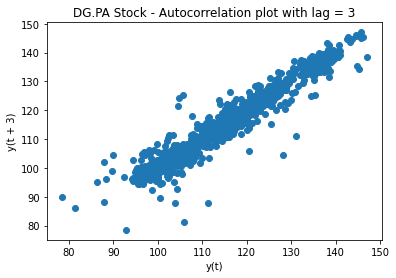

In [35]:
plt.figure()
lag_plot(df['Return_DG.PA_R'], lag=3)
plt.title('DG.PA Stock - Autocorrelation plot with lag = 3')
plt.show()


Nous pouvons maintenant confirmer que le modèle ARIMA sera un bon modèle à appliquer à ce type de données (il y a une auto-corrélation dans les données).

## Etape 2: Etude de la stationnarité

* **CONTEXTE:** 

Comme nous le voyons dans les paramètres requis par le modèle(cf préambule 2.), l'utilisation des modèles ARIMA requiert que **les séries temporelles soit stationnaire**.
D'où la nécessité de réaliser une étude de stationnarité.

* **TEST DE STATIONNARITE: Augumented Dickey Fuller (ADF) :**

Il s'agit d'un test d’hypothèse permettant de verifier la stationnarité de notre time series:

**H0:** la série temporelle est non stationnaire.

**H1:** la série temporelle est stationnaire.

**Régle de décision:** Ainsi, si la p-value du test est inférieure au seuil de signification (0,05), nous pouvons rejeter l'hypothèse nulle et en déduire que la série chronologique est effectivement stationnaire.
Donc, dans notre cas, si la valeur p-value > 0,05, nous devrons trouver l'ordre de différenciation.

In [36]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.4188384194557973
p-value: 0.13648984205969683


Ainsi, notre serie temporelle est non stationnaire.
Pour la rendre stationnaire nous allons utiliser **la differencing Method**:
* Cela signifie que nous prenons la différence entre chaque valeur et la précédente (première différence).
* L'objectif est de repeter ce processus jusqu'à obtenir l'orde minimum de différentiation dont nous avons besoin pour rendre notre serie temporelle stationnaire 

Nous allons tracer les courbes d'ACF les visualiser, et imprimez leur p-value adfuller pour être sûr

ADF Statistic: -2.4188384194557973
p-value: 0.13648984205969683


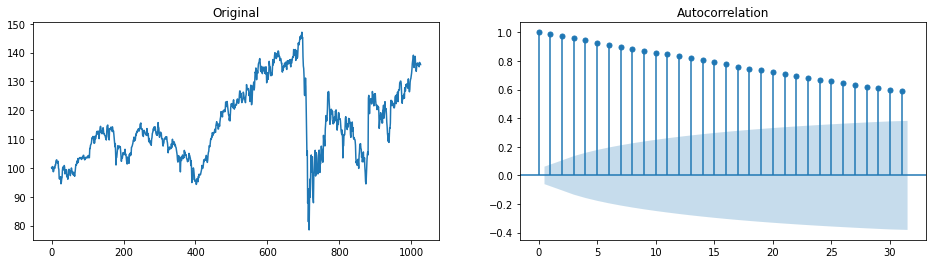

In [37]:

from statsmodels.graphics.tsaplots import plot_acf

# ADF Test Original
result = adfuller(y.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(y)
ax1.set_title("Original")
plot_acf(y, ax=ax2);



* **Première Différence**

ADF Statistic: -7.824958942510863
p-value: 6.518792002871168e-12


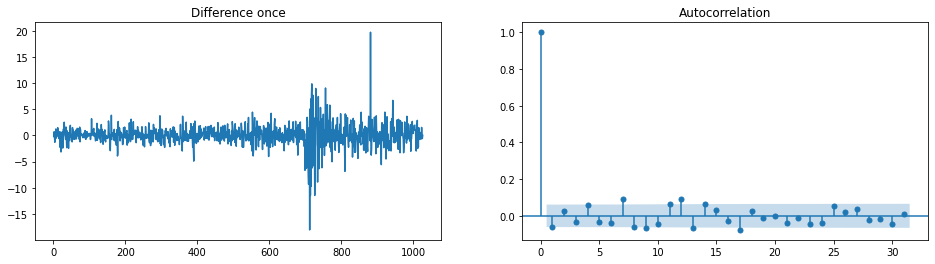

In [39]:
# as stationary wre don't do this step

# ADF Test Première Différence
result = adfuller(y.diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Première Différence
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

* **Deuxième Différence**

ADF Statistic: -12.31658707482109
p-value: 6.899790301248751e-23


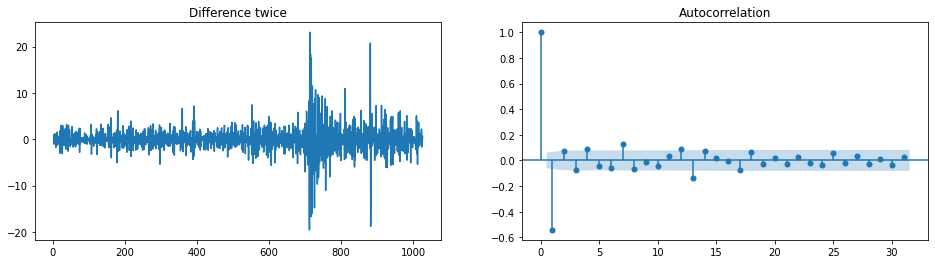

In [44]:
# as stationary wre don't do this step

# ADF Test Deuxième Différence
result = adfuller(y.diff(1).diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Deuxième Différence
diff = y.diff(1).diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);


* **Notre Choix:** 

Ne gardons qu'un seul ordre de diff et nommons cette série y_diff (nous pourrons toujours essayer d'autres diff plus tard).

In [45]:
# as stationary wre don't do this step
y_diff = y.diff().dropna()

## Etape 3: Choix du paramètres ARIMA(p, d, q):

* **Le choix du d :**

Effectuez un test de stationnarité pour différents niveaux de **d** pour estimer le nombre de différences nécessaires pour rendre une série chronologique donnée stationnaire. Sélectionne la valeur maximale **d** pour laquelle la série temporelle est jugée stationnaire par le test statistique.



In [ ]:
!pip install statsmodels

In [23]:
!pip install pmdarima

  Using cached pmdarima-1.8.2-cp38-cp38-macosx_10_13_x86_64.whl
  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
  Using cached Cython-0.29.23-cp38-cp38-macosx_10_9_x86_64.whl (1.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


In [ ]:
!pip list 

In [24]:
from pmdarima.arima import auto_arima

In [25]:
from pmdarima.arima.utils import ndiffs

In [41]:
ndiffs(y, test="adf")

1

* **Le choix du p :**

**p** est l'ordre du terme autorégressif (AR). Il fait référence au nombre de retards à utiliser comme prédicteurs.

Nous pouvons déterminer le nombre requis de termes AR en inspectant le graphique d'autocorrélation partielle (PACF).

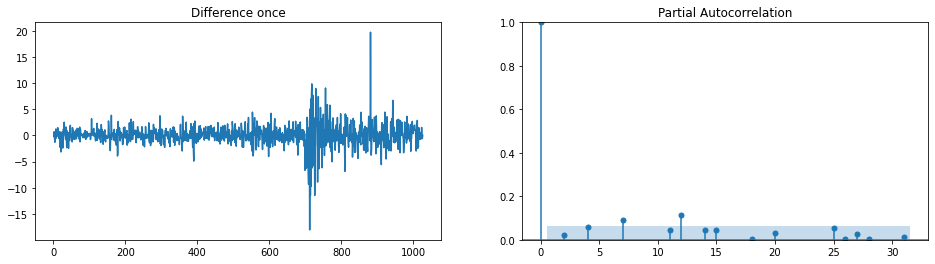

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = y.diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

* **Le choix du q :**

**q** est l'ordre du terme Moving Average (MA). Il s'agit du nombre d'erreurs de prévision décalées qui doivent être intégrées dans le modèle ARIMA.

Nous pouvons déterminer le nombre requis de termes MA en inspectant le graphique d'autocorrélation (ACF).

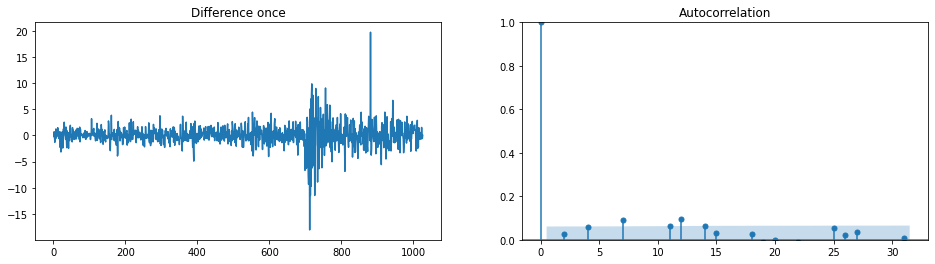

In [49]:
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Commenter le choix des parametres.... 

## Etape 4: Construire le modèle prédictif ARIMA

* **ARIMA(1,1,1)**

In [50]:
from statsmodels.tsa.arima_model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Return_DG.PA_R   No. Observations:                 1026
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2210.747
Method:                       css-mle   S.D. of innovations              2.087
Date:                Wed, 09 Jun 2021   AIC                           4429.495
Time:                        19:56:42   BIC                           4449.228
Sample:                             1   HQIC                          4436.985
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0349      0.063      0.557      0.578      -0.088       0.158
ar.L1.D.Return_DG.PA_R    -0.6184      0.192     -3.226      0.001      -0.994      -0.243
ma.L1.D.Return_DG.PA_R     0.5590      0.201      2.775      0.006       0.164       0.954
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6169           +0.0000j            1.6169            0.5000
MA.1           -1.7889           +0.0000j            1.7889            0.5000
-----------------------------------------------------------------------------
"""

**REMARQUE(à Améliorer):**
Il semble que les modèles ARIMA (1,1,1) ont moins de chance d'être surajustés (les valeurs p restent faibles) et maintiennent un score AIC quasi similaire à celui des autres modèles.

* **Évaluer les performances du modèle**

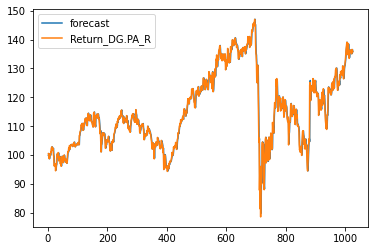

In [51]:
 # Actual vs Fitted
arima.plot_predict(dynamic=False);

**REMARQUE:**

* **dynamic=False :** Il utilise en fait toutes les valeurs y disponibles afin de prédire y_pred, ce qui fait que notre prédiction ARIMA utilise jusqu'à 𝑦𝑡-1 pour prédire 𝑦𝑡 . 

* En réalité, nous n'avons pas accès à tous les y, surtout si nous voulons prédire plusieurs intervalles dans le futur.


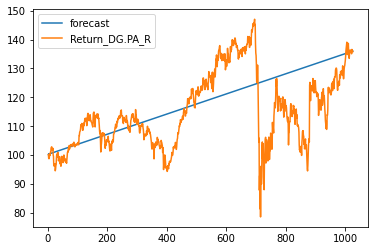

In [52]:
arima.plot_predict(dynamic= True);

**REMARQUE:**

* **dynamic= True :** Si dynamic est True, les prévisions dans l'échantillon sont utilisées à la place des variables dépendantes décalées. La première valeur de prévision est start.



## Etape 5: Prédiction réelle

Jusqu'à présent notre modèle a vu **toute la série y** pendant la phase d'ajustement ! Pour cette raison, nous allons spliter nos données.

* **TRAIN-TEST-SPLIT :**
Nous divisons les données en un ensemble d'apprentissage (70 %) et un ensemble de test (30 %). 

In [77]:
y

0       100.000000
1        99.781294
2       100.463127
3       100.090060
4        98.764958
           ...    
1022    135.047288
1023    136.558796
1024    136.427998
1025    135.817573
1026    135.817573
Name: Return_DG.PA_R, Length: 1027, dtype: float64

In [121]:
y_train = y[0:1025]
y_test = y[1025:]
arima = ARIMA(y_train, order=(1, 1, 0)).fit() 


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [122]:
y_train.shape

(1025,)

In [123]:
y_test

1025    135.817573
1026    135.817573
Name: Return_DG.PA_R, dtype: float64

In [135]:
forecast

1025    136.473846
1026    136.508812
Name: forecast, dtype: float64

In [125]:
y_test.shape

(2,)

* Nous allons utiliser **la méthode .forecast()** sur notre ARIMA.fit() pour "prévoir" les 30% de points de données restant.

In [126]:
(forecast, stderr, conf_int) = arima.forecast(2, alpha=0.05)

In [127]:
forecast = pd.Series(forecast, name='forecast')
stderr = pd.Series(stderr)
conf_int = pd.DataFrame(conf_int, columns=['low', 'high'])

* Nous allons representer graphiquement les valeurs prévues ainsi que la fourchette supérieure et inférieure de l'intervalle d'incertitude de 95%.

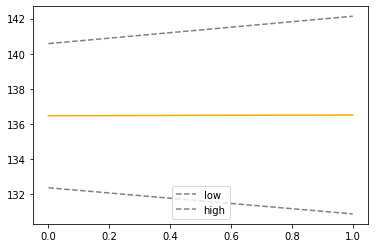

In [128]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend()

Traçons nos points de données réels des 70% de points de données précédents pour mieux saisir les performances du modèle par rapport au passé.

In [129]:
forecast.index = y_test.index
conf_int.index = y_test.index

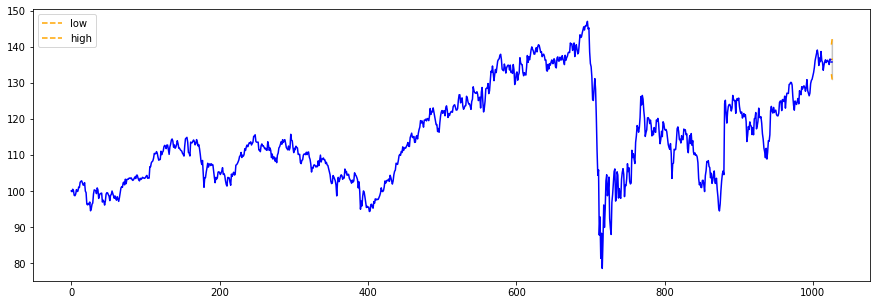

In [130]:
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')
plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15)

* **Verification des certaines hypohtèses portant sur les résidus:** 
1. Distribution normale 
2. Moyenne constante 
3. Variance constante
4. Covariance constance 



(<AxesSubplot:title={'center':'Residuals'}>,
 <AxesSubplot:title={'center':'Residual density'}, ylabel='Density'>)

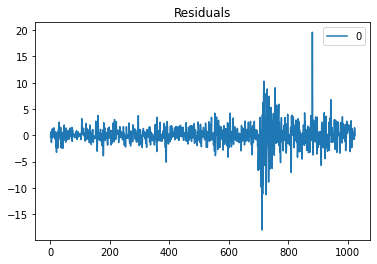

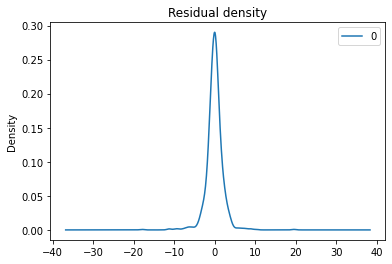

In [131]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals"), residuals.plot(kind='kde', title='Residual density')

* **Metrics de performances :**

In [132]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [133]:
forecast_accuracy(forecast, y_test)

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  >>> plt.figure()
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


{'mape': 0.004960741452822529,
 'me': 0.6737558654031375,
 'mae': 0.6737558654031375,
 'mpe': 0.004960741452822529,
 'rmse': 0.6739826668422534,
 'acf1': -0.5,
 'corr': nan,
 'minmax': 0.0049362376466486335}

In [134]:
forecast

1025    136.473846
1026    136.508812
Name: forecast, dtype: float64

## Etape 6: Grid Search

* **Executons notre propre gridsearch pour trouver nos meilleurs paramètres(p,d,q)**

In [70]:
import pmdarima as pm

model = pm.auto_arima(y_train, 
                      start_p=0, max_p=3,
                      start_q=0, max_q=3, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2799.774, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2791.011, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2794.466, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2797.865, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2751.221, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2750.248, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2745.164, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2743.658, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2755.609, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2735.721, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2744.676, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2736.250, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2735.955, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2746.383, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

### sklearn.TimeSeriesSplit

* Afin d'évaluer réellement les performances de notre modèle et trouver les meilleurs hyper-paramètres 
Nous allons utiliser **sklearn.TimeSeriesSplit** pour créer des K-folds continus.
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [71]:
model = ARIMA(y_train, order=(2,0,2)).fit()
model

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [72]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools

range_p = [0,1,2]
range_d = [0,1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
print(next(grid))
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        print(order)
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        #import ipdb;ipdb.set_trace()
        try: 
            model = ARIMA(y_train, order=order).fit()
            # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
            # r2s.append(r2_score(y_pred, y_true))
            orders.append(order)
            aics.append(model.aic)
        except:
            pass
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC'])#, 'R2'])

(0, 0, 0)
(0, 0, 1)
(0, 0, 1)
(0, 0, 1)
(0, 0, 2)
(0, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(0, 0, 2)
(0, 1, 0)
(0, 1, 0)
(0, 1, 0)
(0, 1, 1)
(0, 1, 1)
(0, 1, 1)
(0, 1, 2)
(0, 1, 2)
(0, 1, 2)
(0, 2, 0)
(0, 2, 0)
(0, 2, 0)
(0, 2, 1)
(0, 2, 1)
(0, 2, 1)
(0, 2, 2)
(0, 2, 2)
(0, 2, 2)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 1)
(1, 0, 1)
(1, 0, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

(1, 0, 2)
(1, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

(1, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 1, 0)
(1, 1, 0)
(1, 1, 0)
(1, 1, 1)
(1, 1, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

(1, 1, 1)
(1, 1, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 1, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

(1, 1, 2)
(1, 2, 0)
(1, 2, 0)
(1, 2, 0)
(1, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arnaudraybaud/.pyenv/versions/3.8

(1, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(1, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 0, 0)
(2, 0, 0)
(2, 0, 0)
(2, 0, 1)
(2, 0, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 0, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 0, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 1, 0)
(2, 1, 0)
(2, 1, 0)
(2, 1, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/tsa

(2, 1, 1)
(2, 1, 1)
(2, 1, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

(2, 1, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 1, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 2, 0)
(2, 2, 0)
(2, 2, 0)
(2, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 2, 1)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(2, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnin

(2, 2, 2)


/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [73]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(1, 1, 0)    1872.711874
(0, 1, 0)    1872.735881
(0, 1, 1)    1872.877324
(1, 1, 1)    1873.541481
(2, 1, 0)    1874.043912
(0, 1, 2)    1874.158238
(2, 1, 1)    1874.847099
(2, 1, 2)    1874.859377
(1, 1, 2)    1874.896203
(0, 2, 1)    1878.375450
(1, 2, 1)    1878.402927
(0, 2, 2)    1878.567879
(1, 0, 0)    1879.359394
(2, 0, 0)    1879.564042
(1, 2, 2)    1879.578787
(2, 2, 1)    1879.710216
(1, 0, 1)    1879.727585
(2, 0, 1)    1880.693111
(1, 0, 2)    1880.883601
(2, 2, 2)    1881.097689
(2, 0, 2)    1882.222939
(2, 2, 0)    2022.774125
(1, 2, 0)    2078.338716
(0, 2, 0)    2249.081729
(0, 0, 1)    3154.950876
(0, 0, 2)    3570.502858
Name: AIC, dtype: float64